In [ ]:
!pip install nltk
!pip install --upgrade nltk
!pip install wordcloud
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


In [ ]:
#Upload data set 
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
#Machine learning libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#Text cleaning library
import nltk

#Load data set
import io
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))


# **Exploring the data set**






In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
# Rename columns for accuracy
df.rename(columns = {'title':'post_title' , 'Column1' : 'post' , 'post number' : 'time' , 'diagnosis' : 'disorder' }, inplace = True)



# **Data Cleaning and transformation**


In [ ]:
# Checking the total number of null values of each feature
df.isnull().sum()

title            0
Column1        524
post number      0
over 18          0
diagnosis        0
dtype: int64

In [ ]:
#Drop null values
df = df.dropna(axis=0)

# Checking the total number of null values of each feature after dropping
df.isnull().sum()

title          0
Column1        0
post number    0
over 18        0
diagnosis      0
dtype: int64

In [ ]:
#Drop irrelevant columns
df = df.drop('time', axis = 1)
df.head()

,title,post,over 18,disorder
0,I don’t understand how. I addressed every poin...,she just wasn't hearing me. I apologized for ...,we had a whole conversation about it,and I told her that I’d go once I move out we...
1,derly alone in hospices alone,not receiving visit from their family,"we feel tremendo""",1619282010
2,d start kicking the front door in. For about 1...,I smash the door at the bottom in,1644363249,FALSE
3,step back and start kicking the front door in...,I smash the door at the bottom in,1641627602,FALSE
4,Just need help.,*I know everyone is just going to say go to a ...,TRUE,schizophrenia


In [ ]:
# Find unique values 
df.disorder.unique()

array([' and I told her that I’d go once I move out west because I didn’t want to have to deal with looking for a provider',
       '1619282010', 'FALSE', 'schizophrenia', 'depression', 'Anxiety',
       'BPD', 'bipolar'], dtype=object)

In [ ]:
df.drop(df[df['disorder'] == ' and I told her that I’d go once I move out west because I didn’t want to have to deal with looking for a provider'].index, inplace = True)
df.drop(df[df['disorder'] == 'FALSE'].index, inplace = True)
df.drop(df[df['disorder'] == '1619282010'].index, inplace = True)

In [ ]:
# Find unique values 
df.disorder.unique()

array(['schizophrenia', 'depression', 'Anxiety', 'BPD', 'bipolar'],
      dtype=object)

In [ ]:
#Combine BPD with Bipolar values
df = df.replace("BPD", "bipolar")
df.disorder.unique()

array([' and I told her that I’d go once I move out west because I didn’t want to have to deal with looking for a provider',
       '1619282010', 'FALSE', 'schizophrenia', 'depression', 'Anxiety',
       'bipolar'], dtype=object)

# **Possible disorders values** (from 15,214 reddit posts)

Schizophrenia

depression

Anxiety

Bipolar











# **Text pre-processing**

In [ ]:
 # 1- Lower case post text and remove any digits

df['post'] = df['post'].apply(lambda posts : re.sub(r"[0-9]", " ", posts.lower()))
df['post']

In [ ]:
# 2- Remove punctuation marks by tokenization

# Split text into tokens
from nltk import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

df['post'] = df['post'].apply(lambda x: tokenizer.tokenize(x))
df['post']

# Remove punctuation
import string

df['post'] = df['post'].apply(lambda x : list(filter(None,[word.replace('.', '').replace('_','').replace('-','').replace("'","" ).replace("`","").replace('*','') for word in x if word not in string.punctuation])))

df['post']

In [ ]:
 # 3- Remove stop words (All english stop words)

#import all english stop words
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# Handle negations to avoid destroying sentence meaning (remove from stopword list)

negation_list = ["no","nor", "not", "n't"]

stop_words = [word for word in stop_words if word not in negation_list]
stop_words

# Removing stopwords from "post" Column

df['post'] = df['post'].apply(lambda x: [word for word in x if word not in stop_words])
df['post'].tolist()
df['post']

In [ ]:
# 4- Transforming words into their root (Stemming)  ex: 'studies → study / studying → study'
df['post']

from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

df['post'] = df['post'].apply(lambda x: [stemmer.stem(word) for word in x])

df['post']

In [ ]:
# 5- Remove elongated words (Lemmatization)  ex: 'studies → study / studying → study'
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df['post'] = df['post'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

df['post']

In [ ]:
# Join all words in a post into a string

df['post']= df['post'].apply(lambda x : " ".join(x))
df['post']

# **Data visualization**

[Text(0, 0, '739'), Text(0, 0, '3187'), Text(0, 0, '4991'), Text(0, 0, '5768')]

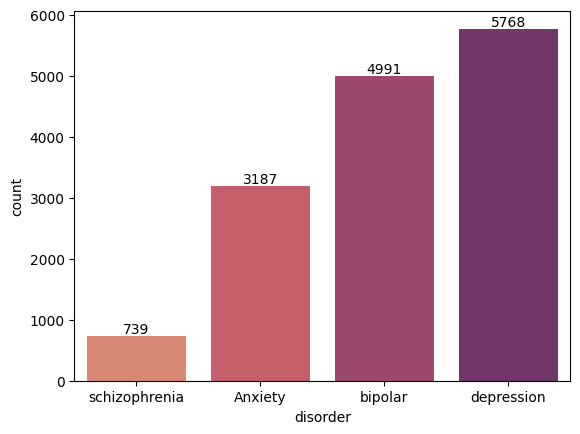

In [ ]:
# Occurences of each disorder
ax = sns.countplot(x = 'disorder', data = df, order=df['disorder'].value_counts(ascending=True).index, palette = 'flare')
ax.bar_label(ax.containers[0])

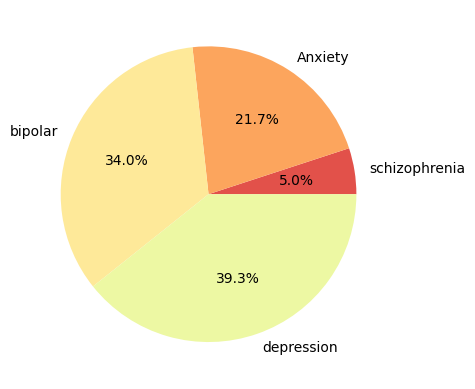

In [ ]:
#Percentage of disorders from data set

df1 = pd.DataFrame(df['disorder'].value_counts(ascending=True).reset_index())

plt.pie(data=df1, x='disorder',labels='index', autopct='%.1f%%', colors=sns.color_palette('Spectral'))
plt.show()

# **Modeling** 
(Linear Support vector machine / Logistic regression / Naive bayes / Random forests)

In [ ]:
#Split data into training and testing 
# Total posts = 15,214
# 90% training (13,726)  
# 10% testing (1,488)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

X = df['post']            #Independent Variable
y = df['disorder']        #Dependent Variable

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [ ]:
#Encode post data using bag of words approach 
from nltk import ngrams

count_vect = CountVectorizer(max_features= 1000, ngram_range=(1,3))

x_train_post = count_vect.fit_transform(x_train) #transformed train reviews

x_test_post = count_vect.transform(x_test) #transformed test reviews

print('BOW_train:', x_train_post.shape)
print('BOW_test:', x_test_post.shape)

BOW_train: (13216, 1000)
BOW_test: (1469, 1000)


In [ ]:
#Define classifiers
rf_clf = RandomForestClassifier(random_state=42)
svc_clf = LinearSVC(C=10)
lr_clf = LogisticRegression(C=10)
nb_clf = MultinomialNB(alpha=1)


In [ ]:
# Define the parameter grids for each classifier
rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 20]}
svc_param_grid = {'C': [0.1, 1, 10]}
lr_param_grid = {'C': [0.1, 1, 10]}
nb_param_grid = {'alpha': [0.1, 1, 10]}

In [ ]:
#Random forests classifier
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5)

In [ ]:
# Support vector machine classifier
svc_param_grid = {'C': [0.1, 1, 10]}
svc_grid = GridSearchCV(svc_clf, svc_param_grid, cv=5)

In [ ]:
# Logistic regression classifier
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
x_train_scaled = scaler.fit_transform(x_train_post)
x_test_scaled = scaler.transform(x_test_post)

lr_grid = GridSearchCV(lr_clf, lr_param_grid, cv=5)


In [ ]:
# Naive Bayes classifier
nb_param_grid = {'alpha': [0.01, 0.1, 1, 10]}
nb_grid = GridSearchCV(nb_clf, nb_param_grid, cv=5)

In [ ]:
# Fit the models
rf_clf.fit(x_train_post, y_train)
svc_clf.fit(x_train_post, y_train)
lr_clf.fit(x_train_post, y_train)
nb_clf.fit(x_train_post, y_train)

MultinomialNB(alpha=1)

In [ ]:
# Predict with the models
rf_y_pred = rf_clf.predict(x_test_post)
svc_y_pred = svc_clf.predict(x_test_post)
lr_y_pred = lr_clf.predict(x_test_post)
nb_y_pred = nb_clf.predict(x_test_post)

# **Evaluation**

In [ ]:
classifiers = [('Random forests', rf_y_pred), ('Linear SVC', svc_y_pred), ('Logistic Regression', lr_y_pred), ('Naive Bayes', nb_y_pred)]
for clf in classifiers:
  print('Classifier:', clf[0]) 
  print('Accuracy:', accuracy_score(y_test, clf[1]))
  print('F1 Score:', f1_score(y_test, clf[1], average='weighted'))

In [ ]:

accuracy_scores = []
f1_scores = []

for clf in classifiers:
    accuracy = accuracy_score(y_test, clf[1])
    f1 = f1_score(y_test, clf[1], average='weighted')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    print('Classifier:', clf[0])
    print('Accuracy:', accuracy)
    print('F1 Score:', f1)
    print()

# Plotting the accuracy scores
plt.figure(figsize=(10, 5))
sns.barplot(x=[clf[0] for clf in classifiers], y=accuracy_scores, palette = 'crest')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores of Classifiers')
for i in range(len(classifiers)):
    plt.text(i, accuracy_scores[i], f"{accuracy_scores[i]:.3f}", ha='center', va='bottom')
plt.show()

# Plotting the F1 scores
plt.figure(figsize=(10, 5))
sns.barplot(x=[clf[0] for clf in classifiers], y=f1_scores, palette = 'crest')
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Classifiers')
for i in range(len(classifiers)):
    plt.text(i, f1_scores[i], f"{f1_scores[i]:.3f}", ha='center', va='bottom')
plt.show()

# Report

In [ ]:
# Evaluate the classifiers
classifiers = [('Random forests', rf_y_pred), ('Linear SVC', svc_y_pred), ('Logistic Regression', lr_y_pred), ('Naive Bayes', nb_y_pred)]

for clf in classifiers:
    print('Classifier:', clf[0])
    print('Accuracy:', accuracy_score(y_test, clf[1]))
    print('Precision:', precision_score(y_test, clf[1], average='weighted'))
    print('Recall:', recall_score(y_test, clf[1], average='weighted'))
    print('F1 Score:', f1_score(y_test, clf[1], average='weighted'))
    print('Confusion Matrix:\n', confusion_matrix(y_test, clf[1]))



In [ ]:
# Print the classification report for each model
print('Random forest classifier\n', classification_report(y_test, rf_y_pred))
print('Linear SVC classifier\n', classification_report(y_test, svc_y_pred))
print('Logistic Regression Classifier\n', classification_report(y_test, lr_y_pred))
print('Naive Bayes Classifier\n', classification_report(y_test, nb_y_pred))

Random forest classifier
                precision    recall  f1-score   support

      Anxiety       0.86      0.69      0.76       308
      bipolar       0.80      0.56      0.66       505
   depression       0.62      0.91      0.74       578
schizophrenia       0.82      0.18      0.29        78

     accuracy                           0.71      1469
    macro avg       0.77      0.59      0.61      1469
 weighted avg       0.74      0.71      0.69      1469

Linear SVC classifier
                precision    recall  f1-score   support

      Anxiety       0.77      0.72      0.74       308
      bipolar       0.83      0.49      0.62       505
   depression       0.62      0.86      0.72       578
schizophrenia       0.32      0.29      0.31        78

     accuracy                           0.67      1469
    macro avg       0.63      0.59      0.60      1469
 weighted avg       0.71      0.67      0.67      1469

Logistic Regression Classifier
                precision    recal